In [1]:
!git clone https://github.com/Franck-Dernoncourt/pubmed-rct.git
!ls pubmed-rct

Cloning into 'pubmed-rct'...
remote: Enumerating objects: 33, done.
remote: Counting objects: 100% (8/8), done.
remote: Compressing objects: 100% (3/3), done.
remote: Total 33 (delta 5), reused 5 (delta 5), pack-reused 25
Unpacking objects: 100% (33/33), done.
PubMed_200k_RCT
PubMed_200k_RCT_numbers_replaced_with_at_sign
PubMed_20k_RCT
PubMed_20k_RCT_numbers_replaced_with_at_sign
README.md


In [2]:
!wget "https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py"
from helper_functions import plot_loss_curves,calculate_results

--2022-11-25 13:25:45--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0s      

2022-11-25 13:25:45 (108 MB/s) - ‘helper_functions.py’ saved [10246/10246]



In [3]:
data_dir = "/content/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/"

In [4]:
def get_lines(filename):

  with open(filename, "r") as f:
    return f.readlines()

In [5]:
train_lines = get_lines(data_dir+"train.txt")
train_lines[:10]

['###24293578\n',
 'OBJECTIVE\tTo investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( OA ) .\n',
 'METHODS\tA total of @ patients with primary knee OA were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .\n',
 'METHODS\tOutcome measures included pain reduction and improvement in function scores and systemic inflammation markers .\n',
 'METHODS\tPain was assessed using the visual analog pain scale ( @-@ mm ) .\n',
 'METHODS\tSecondary outcome measures included the Western Ontario and McMaster Universities Osteoarthritis Index scores , patient global assessment ( PGA ) of the severity of knee OA , and @-min walk distance ( @MWD ) .\n',
 'METHODS\tSerum levels of interleukin @ ( IL-@ ) , IL-@ , tumor necrosis factor ( TNF ) - , and 

In [6]:
def preprocess_text_with_line_numbers(filename):
  
  input_lines = get_lines(filename)
  abstract_lines = ""
  abstract_samples = []

  for line in input_lines:

    if line.startswith("###"):
      abstract_id = line
      abstract_lines = ""

    elif line.isspace():
      abstract_line_split = abstract_lines.splitlines()  

      for abstract_line_number, abstract_line in enumerate(abstract_line_split):
        line_data = {}
        target_text_split = abstract_line.split("\t")
        line_data["target"] = target_text_split[0]
        line_data["text"] = target_text_split[1].lower()
        line_data["line_number"] = abstract_line_number
        line_data["total_lines"] = len(abstract_line_split)-1
        abstract_samples.append(line_data)
        
    else:
      abstract_lines += line

  return abstract_samples        

In [7]:
train_samples = preprocess_text_with_line_numbers(data_dir+"train.txt")
val_samples = preprocess_text_with_line_numbers(data_dir+"dev.txt")
test_samples = preprocess_text_with_line_numbers(data_dir+"test.txt")

In [8]:
import pandas as pd

train_df = pd.DataFrame(train_samples)
val_df = pd.DataFrame(val_samples)
test_df = pd.DataFrame(test_samples)

In [9]:
train_sentences = train_df["text"].tolist()
val_sentences = val_df["text"].tolist()
test_sentences = test_df["text"].tolist()

In [10]:
from sklearn.preprocessing import OneHotEncoder

one_hot_encoder = OneHotEncoder(sparse=False)
train_labels_one_hot = one_hot_encoder.fit_transform(train_df["target"].to_numpy().reshape(-1,1))
val_labels_one_hot = one_hot_encoder.fit_transform(val_df["target"].to_numpy().reshape(-1,1))
test_labels_one_hot = one_hot_encoder.fit_transform(test_df["target"].to_numpy().reshape(-1,1))

In [11]:
from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()
train_labels_encoded = label_encoder.fit_transform(train_df["target"].to_numpy())
val_labels_encoded = label_encoder.fit_transform(val_df["target"].to_numpy())
test_labels_encoded = label_encoder.fit_transform(test_df["target"].to_numpy())

In [12]:
num_classes = len(label_encoder.classes_)
class_names = label_encoder.classes_
num_classes, class_names

(5, array(['BACKGROUND', 'CONCLUSIONS', 'METHODS', 'OBJECTIVE', 'RESULTS'],
       dtype=object))

In [13]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline

In [14]:
model0 = Pipeline([
    ("tf-idf",TfidfVectorizer()),
    ("clf", MultinomialNB())
])

model0.fit(X=train_sentences,y=train_labels_encoded)

Pipeline(steps=[('tf-idf', TfidfVectorizer()), ('clf', MultinomialNB())])

In [15]:
model0.score(val_sentences,val_labels_encoded)

0.7218323844829869

In [16]:
baseline_preds = model0.predict(val_sentences)
baseline_preds

array([4, 1, 3, ..., 4, 4, 1])

In [17]:
baseline_results = calculate_results(y_true = val_labels_encoded,
                                     y_pred = baseline_preds)
baseline_results

{'accuracy': 72.1832384482987,
 'precision': 0.7186466952323352,
 'recall': 0.7218323844829869,
 'f1': 0.6989250353450294}

In [18]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers

In [19]:
sent_lens = [len(sentence.split()) for sentence in train_sentences]
avg_sent_lens = np.mean(sent_lens)
avg_sent_lens

26.338269273494777

(array([1.6499e+04, 5.6664e+04, 5.2683e+04, 2.9050e+04, 1.3111e+04,
        5.6610e+03, 3.0490e+03, 1.5190e+03, 8.0800e+02, 4.3200e+02,
        2.2600e+02, 1.2800e+02, 7.7000e+01, 3.9000e+01, 3.0000e+01,
        1.5000e+01, 9.0000e+00, 8.0000e+00, 4.0000e+00, 8.0000e+00,
        7.0000e+00, 5.0000e+00, 1.0000e+00, 2.0000e+00, 3.0000e+00,
        0.0000e+00, 0.0000e+00, 1.0000e+00, 0.0000e+00, 1.0000e+00]),
 array([  1.        ,  10.83333333,  20.66666667,  30.5       ,
         40.33333333,  50.16666667,  60.        ,  69.83333333,
         79.66666667,  89.5       ,  99.33333333, 109.16666667,
        119.        , 128.83333333, 138.66666667, 148.5       ,
        158.33333333, 168.16666667, 178.        , 187.83333333,
        197.66666667, 207.5       , 217.33333333, 227.16666667,
        237.        , 246.83333333, 256.66666667, 266.5       ,
        276.33333333, 286.16666667, 296.        ]),
 <a list of 30 Patch objects>)

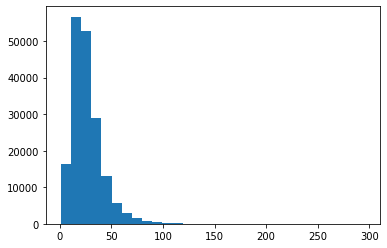

In [20]:
import matplotlib.pyplot as plt
plt.hist(sent_lens,bins=30)

In [21]:
output_seq_length = int(np.percentile(sent_lens,95))
output_seq_length

55

In [22]:
max_tokens = 68000

In [23]:
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization

text_vectorizer = TextVectorization(max_tokens = max_tokens,
                                    output_sequence_length = output_seq_length)

In [24]:
text_vectorizer.adapt(train_sentences)

In [25]:
rct_20k_text_vocab = text_vectorizer.get_vocabulary()
len(rct_20k_text_vocab)

64841

In [26]:
token_embed = layers.Embedding(input_dim = len(rct_20k_text_vocab),
                               output_dim = 128,
                               mask_zero = True,
                               name="token_embedding")

In [27]:
train_dataset = tf.data.Dataset.from_tensor_slices((train_sentences, train_labels_one_hot))
valid_dataset = tf.data.Dataset.from_tensor_slices((val_sentences, val_labels_one_hot))
test_dataset = tf.data.Dataset.from_tensor_slices((test_sentences, test_labels_one_hot))

In [28]:
train_dataset = train_dataset.batch(32).prefetch(tf.data.AUTOTUNE)
valid_dataset = valid_dataset.batch(32).prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

In [29]:
inputs = layers.Input(shape=(1,), dtype = tf.string)
text_vectors = text_vectorizer(inputs)
token_embedding = token_embed(text_vectors)

x = layers.Conv1D(64,kernel_size = 5, padding="same", activation="relu")(token_embedding)
x = layers.GlobalAveragePooling1D()(x)
outputs = layers.Dense(num_classes,activation="softmax", name="output")(x)

model1 = tf.keras.Model(inputs,outputs)

model1.compile(loss="categorical_crossentropy",
               optimizer = tf.keras.optimizers.Adam(),
               metrics = ["accuracy"])

model1.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization (TextVec  (None, 55)               0         
 torization)                                                     
                                                                 
 token_embedding (Embedding)  (None, 55, 128)          8299648   
                                                                 
 conv1d (Conv1D)             (None, 55, 64)            41024     
                                                                 
 global_average_pooling1d (G  (None, 64)               0         
 lobalAveragePooling1D)                                          
                                                                 
 output (Dense)              (None, 5)                 325   

In [30]:
model1.fit(train_dataset,
           steps_per_epoch = int(0.1*len(train_dataset)),
           epochs = 5,
           validation_data = valid_dataset,
           validation_steps = int(0.1*len(valid_dataset)))

Epoch 1/5
562/562 [==============================] - 17s 14ms/step - loss: 0.9168 - accuracy: 0.6373 - val_loss: 0.6879 - val_accuracy: 0.7340
Epoch 2/5
562/562 [==============================] - 7s 13ms/step - loss: 0.6579 - accuracy: 0.7553 - val_loss: 0.6339 - val_accuracy: 0.7723
Epoch 3/5
562/562 [==============================] - 7s 12ms/step - loss: 0.6187 - accuracy: 0.7737 - val_loss: 0.6000 - val_accuracy: 0.7846
Epoch 4/5
562/562 [==============================] - 7s 12ms/step - loss: 0.5895 - accuracy: 0.7883 - val_loss: 0.5827 - val_accuracy: 0.7902
Epoch 5/5
562/562 [==============================] - 6s 11ms/step - loss: 0.5914 - accuracy: 0.7924 - val_loss: 0.5641 - val_accuracy: 0.7949


In [31]:
model1.evaluate(valid_dataset)

945/945 [==============================] - 4s 4ms/step - loss: 0.5624 - accuracy: 0.8002


[0.5623978972434998, 0.8001787662506104]

In [32]:
model1_pred_probs = model1.predict(valid_dataset)
model1_preds = tf.argmax(model1_pred_probs,axis=1)
model1_results = calculate_results(y_true = val_labels_encoded,
                                   y_pred = model1_preds)
model1_results

945/945 [==============================] - 4s 4ms/step


{'accuracy': 80.01787369257248,
 'precision': 0.8003074438896621,
 'recall': 0.8001787369257248,
 'f1': 0.7968766883998488}

In [33]:
import tensorflow_hub as hub

tf_hub_embedding_layer = hub.KerasLayer("https://tfhub.dev/google/universal-sentence-encoder/4",
                                  trainable = False,
                                  name ="universal_sentence_encoder")

In [34]:
inputs = layers.Input(shape = [],dtype=tf.string)
pretrained_embedding = tf_hub_embedding_layer(inputs)
x = layers.Dense(128, activation="relu")(pretrained_embedding)
outputs = layers.Dense(num_classes, activation="softmax")(x)

model2 = tf.keras.Model(inputs, outputs, name = "model2-USE")

model2.compile(loss="categorical_crossentropy",
               optimizer = tf.keras.optimizers.Adam(),
               metrics = ["accuracy"])

model2.summary()

Model: "model2-USE"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None,)]                 0         
                                                                 
 universal_sentence_encoder   (None, 512)              256797824 
 (KerasLayer)                                                    
                                                                 
 dense (Dense)               (None, 128)               65664     
                                                                 
 dense_1 (Dense)             (None, 5)                 645       
                                                                 
Total params: 256,864,133
Trainable params: 66,309
Non-trainable params: 256,797,824
_________________________________________________________________


In [35]:
history2 = model2.fit(train_dataset,
                      epochs = 5,
                      steps_per_epoch = int(0.1*len(train_dataset)),
                      validation_data = valid_dataset,
                      validation_steps = int(0.1*len(valid_dataset)))

Epoch 1/5
562/562 [==============================] - 14s 16ms/step - loss: 0.9163 - accuracy: 0.6507 - val_loss: 0.7948 - val_accuracy: 0.6932
Epoch 2/5
562/562 [==============================] - 9s 17ms/step - loss: 0.7672 - accuracy: 0.7030 - val_loss: 0.7540 - val_accuracy: 0.7071
Epoch 3/5
562/562 [==============================] - 9s 16ms/step - loss: 0.7505 - accuracy: 0.7134 - val_loss: 0.7375 - val_accuracy: 0.7128
Epoch 4/5
562/562 [==============================] - 11s 20ms/step - loss: 0.7158 - accuracy: 0.7262 - val_loss: 0.7075 - val_accuracy: 0.7267
Epoch 5/5
562/562 [==============================] - 12s 21ms/step - loss: 0.7222 - accuracy: 0.7238 - val_loss: 0.6875 - val_accuracy: 0.7347


In [36]:
model2.evaluate(valid_dataset)

945/945 [==============================] - 11s 12ms/step - loss: 0.6945 - accuracy: 0.7366


[0.6945083737373352, 0.7366278171539307]

In [37]:
model2_pred_probs = model2.predict(valid_dataset)
model2_preds = tf.argmax(model2_pred_probs,axis = 1)
model2_results = calculate_results(y_true = val_labels_encoded,
                                   y_pred = model2_preds)
model2_results

945/945 [==============================] - 10s 10ms/step


{'accuracy': 73.66278300013239,
 'precision': 0.732671872273798,
 'recall': 0.7366278300013239,
 'f1': 0.7308559616618702}

In [38]:
def split_chars(text):
  return " ".join(list(text))

In [39]:
train_chars = [split_chars(sentence) for sentence in train_sentences]
val_chars = [split_chars(sentence) for sentence in val_sentences]
test_chars = [split_chars(sentence) for sentence in test_sentences]

In [40]:
chars_lens = [len(sentence) for sentence in train_sentences] 
mean_char_len = np.mean(chars_lens)
mean_char_len

149.3662574983337

In [41]:
output_seq_char_len = int(np.percentile(chars_lens,95))
output_seq_char_len

290

In [42]:
import string
alphabet = string.ascii_lowercase+string.digits+string.punctuation
alphabet

'abcdefghijklmnopqrstuvwxyz0123456789!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

In [43]:
NUM_CHAR_TOKENS = len(alphabet) + 2
char_vectorizer = TextVectorization(max_tokens = NUM_CHAR_TOKENS,
                                    output_sequence_length = output_seq_char_len,
                                    name = "char_vectorizer")

In [44]:
char_vectorizer.adapt(train_chars)

In [45]:
char_vocab = char_vectorizer.get_vocabulary()

In [46]:
char_embed = layers.Embedding(input_dim = len(char_vocab),
                              output_dim = 25,
                              mask_zero=True,
                              name ="char_embed")

In [47]:
inputs = layers.Input(shape = (1,), dtype = tf.string)
char_vectors = char_vectorizer(inputs)
char_embeddings = char_embed(char_vectors)
x = layers.Conv1D(64, kernel_size = 5, padding="same",activation="relu")(char_embeddings)
x = layers.GlobalMaxPool1D()(x)
outputs = layers.Dense(num_classes,activation = "softmax")(x)

model3 = tf.keras.Model(inputs, outputs, name = "model3_char_embedding")

model3.compile(loss = "categorical_crossentropy",
               optimizer = tf.keras.optimizers.Adam(),
               metrics = ["accuracy"])

model3.summary()

Model: "model3_char_embedding"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 1)]               0         
                                                                 
 char_vectorizer (TextVector  (None, 290)              0         
 ization)                                                        
                                                                 
 char_embed (Embedding)      (None, 290, 25)           700       
                                                                 
 conv1d_1 (Conv1D)           (None, 290, 64)           8064      
                                                                 
 global_max_pooling1d (Globa  (None, 64)               0         
 lMaxPooling1D)                                                  
                                                                 
 dense_2 (Dense)             (None, 5)       

In [48]:
train_char_dataset = tf.data.Dataset.from_tensor_slices((train_chars, train_labels_one_hot)).batch(32).prefetch(tf.data.AUTOTUNE)
valid_char_dataset = tf.data.Dataset.from_tensor_slices((val_chars, val_labels_one_hot)).batch(32).prefetch(tf.data.AUTOTUNE)
test_char_dataset = tf.data.Dataset.from_tensor_slices((test_chars, test_labels_one_hot)).batch(32).prefetch(tf.data.AUTOTUNE)

In [49]:
history3 = model3.fit(train_char_dataset,
                      epochs = 5,
                      steps_per_epoch = int(0.1*len(train_char_dataset)),
                      validation_data = valid_char_dataset,
                      validation_steps = int(0.1*len(valid_char_dataset)))

Epoch 1/5
562/562 [==============================] - 4s 6ms/step - loss: 1.2474 - accuracy: 0.4964 - val_loss: 1.0284 - val_accuracy: 0.6001
Epoch 2/5
562/562 [==============================] - 3s 5ms/step - loss: 0.9902 - accuracy: 0.6074 - val_loss: 0.9322 - val_accuracy: 0.6373
Epoch 3/5
562/562 [==============================] - 3s 5ms/step - loss: 0.9141 - accuracy: 0.6460 - val_loss: 0.8565 - val_accuracy: 0.6789
Epoch 4/5
562/562 [==============================] - 3s 5ms/step - loss: 0.8648 - accuracy: 0.6664 - val_loss: 0.8301 - val_accuracy: 0.6832
Epoch 5/5
562/562 [==============================] - 3s 5ms/step - loss: 0.8494 - accuracy: 0.6665 - val_loss: 0.8065 - val_accuracy: 0.6991


In [50]:
model3_pred_probs = model3.predict(valid_char_dataset)
model3_preds = tf.argmax(model3_pred_probs, axis =1 )
model3_results = calculate_results(y_pred = model3_preds,
                                   y_true = val_labels_encoded)
model3_results

945/945 [==============================] - 2s 3ms/step


{'accuracy': 68.26095591155831,
 'precision': 0.6876596124540861,
 'recall': 0.6826095591155832,
 'f1': 0.6776251208139584}

In [51]:
#-------------------------TOKEN MODEL------------------------------
token_inputs = layers.Input(shape = [], dtype = tf.string, name = "token_input")
token_embedding = tf_hub_embedding_layer(token_inputs)
token_output = layers.Dense(128,activation="relu")(token_embedding)

token_model = tf.keras.Model(token_inputs, 
                             token_output)

#-------------------------CHAR MODEL------------------------------
char_inputs = layers.Input(shape = (1,), dtype = tf.string)
char_vectors = char_vectorizer(char_inputs)
char_embedding = char_embed(char_vectors)
char_bi_lstm = layers.Bidirectional(layers.LSTM(24))(char_embedding)

char_model = tf.keras.Model(char_inputs, 
                            char_bi_lstm)

#-------------------------CONCATENATE----------------------------
token_char_concat = layers.Concatenate(name ="token_char_hybrid")([token_model.output,
                                                                   char_model.output])

#

combined_dropout = layers.Dropout(0.5)(token_char_concat)
combined_dense = layers.Dense(128, activation = "relu")(combined_dropout)
final_dropout = layers.Dropout(0.5)(combined_dense)
output_layer = layers.Dense(num_classes, activation= "softmax")(final_dropout)

#Construct model
model4 = tf.keras.Model(inputs = [token_model.input,char_model.input],
                        outputs = output_layer,
                        name = "model4_concat")

In [52]:
model4.summary()

Model: "model4_concat"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_4 (InputLayer)           [(None, 1)]          0           []                               
                                                                                                  
 token_input (InputLayer)       [(None,)]            0           []                               
                                                                                                  
 char_vectorizer (TextVectoriza  (None, 290)         0           ['input_4[0][0]']                
 tion)                                                                                            
                                                                                                  
 universal_sentence_encoder (Ke  (None, 512)         256797824   ['token_input[0][0]']

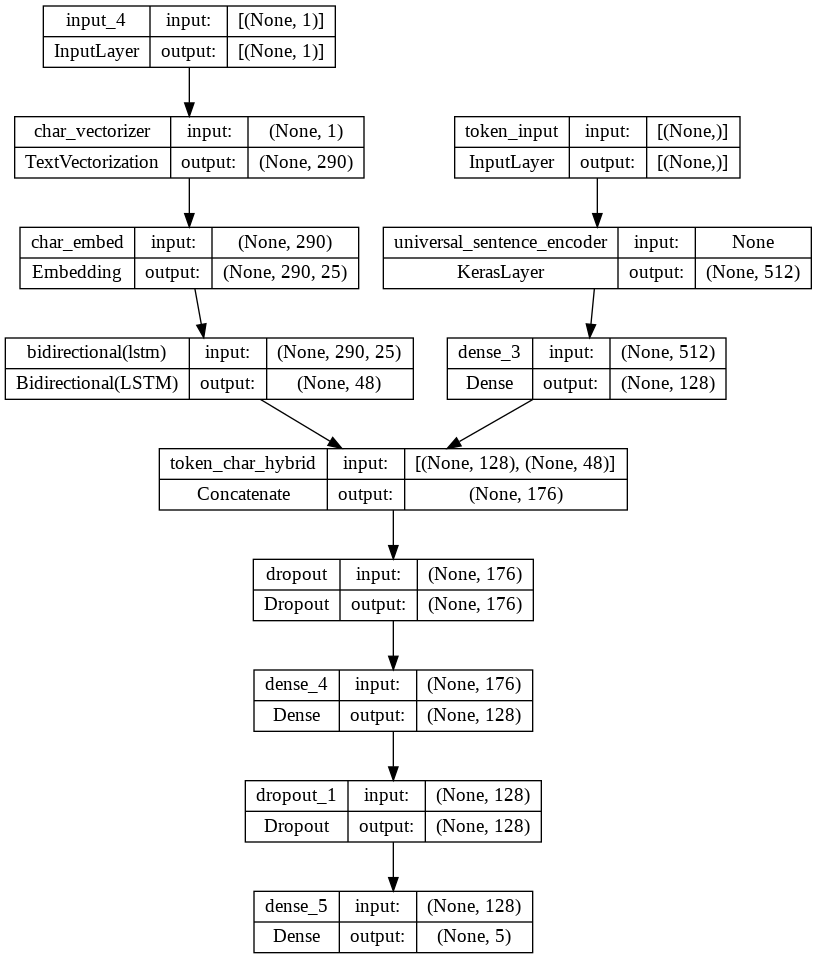

In [53]:
from keras.utils import plot_model
plot_model(model4, show_shapes = True)

In [54]:
model4.compile(loss = "categorical_crossentropy",
               optimizer = tf.keras.optimizers.Adam(),
               metrics = ["accuracy"])

In [55]:
#####TRAIN DATA#####
train_token_char_data = tf.data.Dataset.from_tensor_slices((train_sentences, train_chars))
train_token_char_labels = tf.data.Dataset.from_tensor_slices((train_labels_one_hot))
train_char_token_dataset = tf.data.Dataset.zip((train_token_char_data,train_token_char_labels))

train_char_token_dataset = train_char_token_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

#####VALIDATION DATA#####
valid_token_char_data = tf.data.Dataset.from_tensor_slices((val_sentences, val_chars))
valid_token_char_labels = tf.data.Dataset.from_tensor_slices((val_labels_one_hot))
valid_char_token_dataset = tf.data.Dataset.zip((valid_token_char_data, valid_token_char_labels))

valid_char_token_dataset = valid_char_token_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

#####TEST DATA#####
test_token_char_data = tf.data.Dataset.from_tensor_slices((test_sentences, test_chars))
test_token_char_labels = tf.data.Dataset.from_tensor_slices((test_labels_one_hot))
test_char_token_dataset = tf.data.Dataset.zip((test_token_char_data, test_token_char_labels))

test_char_token_dataset =test_char_token_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

In [56]:
history4 = model4.fit(train_char_token_dataset,
           steps_per_epoch = int(0.1*len(train_char_token_dataset)),
           epochs = 3,
           validation_data = valid_char_token_dataset,
           validation_steps = int(0.1*len(valid_char_token_dataset)))

Epoch 1/3
562/562 [==============================] - 37s 52ms/step - loss: 0.9794 - accuracy: 0.6125 - val_loss: 0.7790 - val_accuracy: 0.6951
Epoch 2/3
562/562 [==============================] - 27s 48ms/step - loss: 0.7985 - accuracy: 0.6908 - val_loss: 0.7109 - val_accuracy: 0.7304
Epoch 3/3
562/562 [==============================] - 30s 54ms/step - loss: 0.7812 - accuracy: 0.7028 - val_loss: 0.6893 - val_accuracy: 0.7384


In [57]:
model4_pred_probs = model4.predict(valid_char_token_dataset)
model4_preds = tf.argmax(model4_pred_probs, axis = 1)
model4_results = calculate_results(y_true = val_labels_encoded,
                                   y_pred = model4_preds)

945/945 [==============================] - 27s 24ms/step


In [58]:
model4_results

{'accuracy': 73.42777704223488,
 'precision': 0.7366234333988558,
 'recall': 0.7342777704223488,
 'f1': 0.7313652232670657}

In [59]:
train_line_numbers_one_hot = tf.one_hot(train_df["line_number"].to_numpy(), depth = 15)
val_line_numbers_one_hot = tf.one_hot(val_df["line_number"].to_numpy(), depth = 15)
test_line_numbers_one_hot = tf.one_hot(test_df["line_number"].to_numpy(), depth = 15)
train_line_numbers_one_hot[:10]

<tf.Tensor: shape=(10, 15), dtype=float32, numpy=
array([[1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.]],
      dtype=float32)>

In [60]:
train_total_lines_one_hot = tf.one_hot(train_df["total_lines"].to_numpy(), depth = 20)
val_total_lines_one_hot = tf.one_hot(val_df["total_lines"].to_numpy(), depth = 20)
test_total_lines_one_hot = tf.one_hot(test_df["total_lines"].to_numpy(), depth = 20)

In [61]:
#-------------------------------------------------------------------------
token_inputs = layers.Input(shape = [], dtype = "string", name ="token_model")
token_embeddings = tf_hub_embedding_layer(token_inputs)
token_outputs = layers.Dense(128, activation = "relu")(token_embeddings)
token_model = tf.keras.Model(token_inputs, token_outputs)
#-------------------------------------------------------------------------
char_inputs = layers.Input(shape = (1,), dtype = "string",name = "char_model")
char_vectors = char_vectorizer(char_inputs)
char_embedding = char_embed(char_vectors)
char_bi_lstm = layers.Bidirectional(layers.LSTM(24))(char_embedding)
char_model = tf.keras.Model(char_inputs, char_bi_lstm)
#-------------------------------------------------------------------------
line_number_inputs = layers.Input(shape = (15,), dtype = tf.int32,name="line_number_input")
x = layers.Dense(32, activation = "relu")(line_number_inputs)
line_number_model = tf.keras.Model(line_number_inputs,x)
#-------------------------------------------------------------------------
total_lines_inputs = layers.Input(shape = (20,), dtype = tf.float32,name="total_line_input")
y = layers.Dense(32, activation = "relu")(total_lines_inputs)
total_lines_model = tf.keras.Model(total_lines_inputs,y)
#-------------------------------------------------------------------------
combined_embedding = layers.Concatenate(name = "char_token_hybrid_embedding")([token_model.output,char_model.output])

z = layers.Dense(256,activation="relu")(combined_embedding)
z = layers.Dropout(0.5)(z)
#-------------------------------------------------------------------------
tribrid_embedding = layers.Concatenate(name="char_token_tribrid_embedding")([line_number_model.output,
                                                                             total_lines_model.output,
                                                                             z])
#-------------------------------------------------------------------------
output_layer = layers.Dense(5, activation="softmax", name="output_layer")(tribrid_embedding)
model5=tf.keras.Model(inputs = [line_number_model.input,
                                total_lines_model.input,
                                token_model.input,
                                char_model.input],
                      outputs = output_layer)

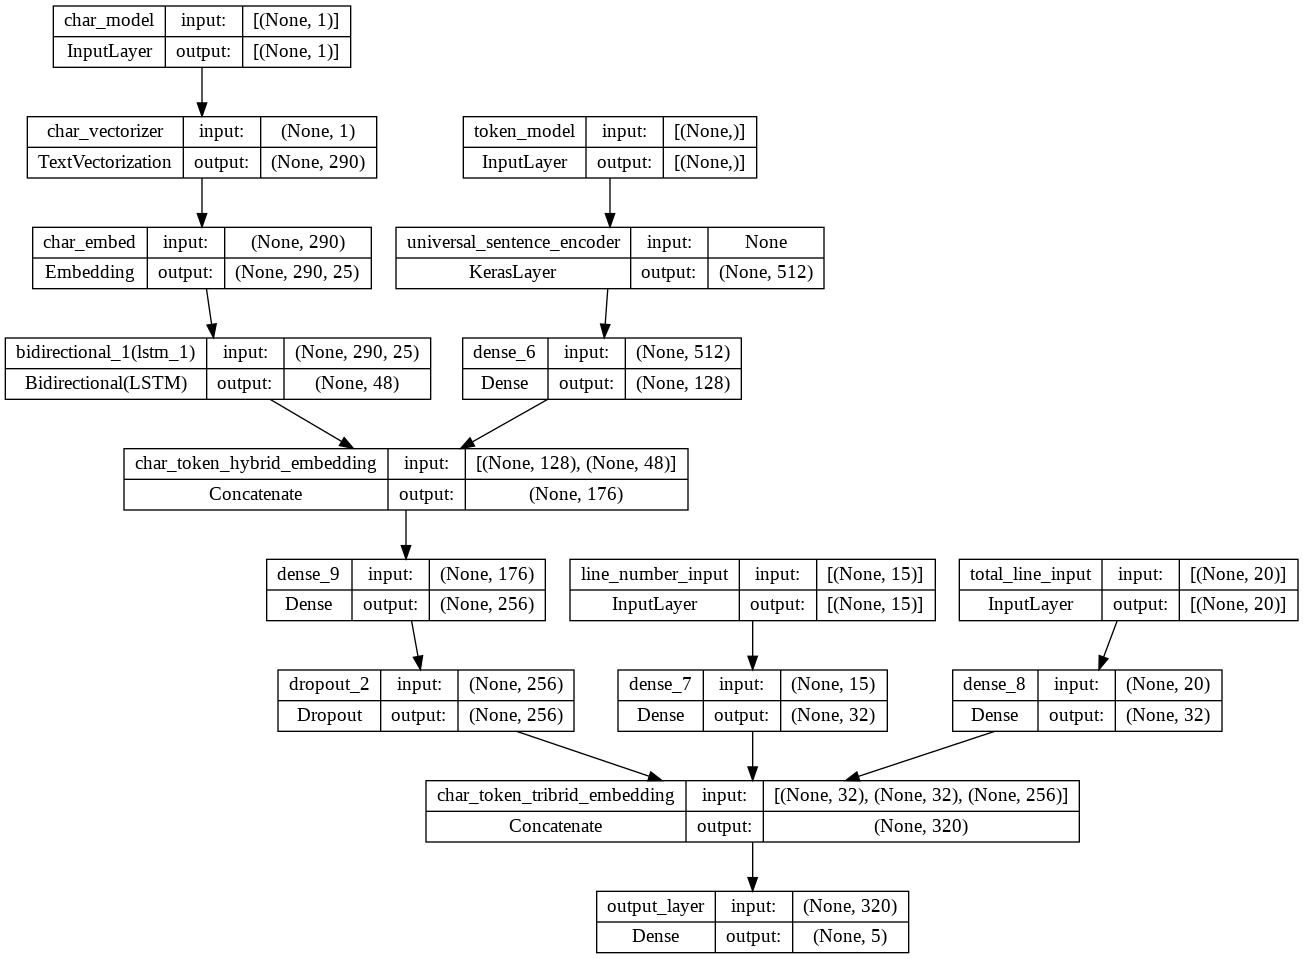

In [62]:
plot_model(model5, show_shapes = True)

In [63]:
model5.compile(loss = tf.keras.losses.CategoricalCrossentropy(label_smoothing=0.2),
               optimizer = tf.keras.optimizers.Adam(),
               metrics = ["accuracy"])

In [64]:
#-------------------------------------------------------------------------------------------------------------
train_char_token_pos_data = tf.data.Dataset.from_tensor_slices((train_line_numbers_one_hot,
                                                                train_total_lines_one_hot,
                                                                train_sentences,
                                                                train_chars))
train_char_token_pos_labels = tf.data.Dataset.from_tensor_slices(train_labels_one_hot)
train_char_token_pos_dataset = tf.data.Dataset.zip((train_char_token_pos_data, train_char_token_pos_labels))
train_char_token_pos_dataset = train_char_token_pos_dataset.batch(32).prefetch(tf.data.AUTOTUNE)
#-------------------------------------------------------------------------------------------------------------
val_char_token_pos_data = tf.data.Dataset.from_tensor_slices((val_line_numbers_one_hot,
                                                                val_total_lines_one_hot,
                                                                val_sentences,
                                                                val_chars))
val_char_token_pos_labels = tf.data.Dataset.from_tensor_slices(val_labels_one_hot)
val_char_token_pos_dataset = tf.data.Dataset.zip((val_char_token_pos_data, val_char_token_pos_labels))
val_char_token_pos_dataset = val_char_token_pos_dataset.batch(32).prefetch(tf.data.AUTOTUNE)
#-------------------------------------------------------------------------------------------------------------

In [65]:
train_char_token_pos_dataset, val_char_token_pos_dataset

(<PrefetchDataset element_spec=((TensorSpec(shape=(None, 15), dtype=tf.float32, name=None), TensorSpec(shape=(None, 20), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None)), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>,
 <PrefetchDataset element_spec=((TensorSpec(shape=(None, 15), dtype=tf.float32, name=None), TensorSpec(shape=(None, 20), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None)), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>)

In [66]:
history5 = model5.fit(train_char_token_pos_dataset,
                      steps_per_epoch = int(0.1*len(train_char_token_dataset)),
                      epochs = 3,
                      validation_data = val_char_token_pos_dataset,
                      validation_steps = int(0.1*len(val_char_token_pos_dataset)))

Epoch 1/3
562/562 [==============================] - 41s 54ms/step - loss: 1.0926 - accuracy: 0.7261 - val_loss: 0.9827 - val_accuracy: 0.8032
Epoch 2/3
562/562 [==============================] - 27s 48ms/step - loss: 0.9658 - accuracy: 0.8151 - val_loss: 0.9485 - val_accuracy: 0.8288
Epoch 3/3
562/562 [==============================] - 25s 44ms/step - loss: 0.9494 - accuracy: 0.8245 - val_loss: 0.9383 - val_accuracy: 0.8311


In [67]:
model5_pred_probs = model5.predict(val_char_token_pos_dataset)
model5_preds = tf.argmax(model5_pred_probs, axis = 1)
model5_results = calculate_results(y_pred = model5_preds,
                                   y_true = val_labels_encoded)
model5_results

945/945 [==============================] - 23s 22ms/step


{'accuracy': 83.45359459817291,
 'precision': 0.8337388876395786,
 'recall': 0.8345359459817291,
 'f1': 0.8331778899087331}

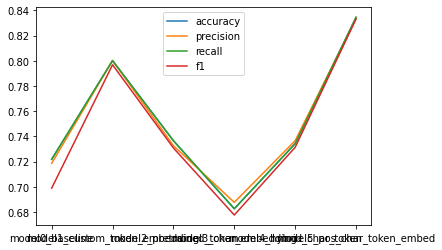

In [69]:
all_model_results = pd.DataFrame({"model0_baseline" : baseline_results,
                                  "model1_custom_token_embedding" : model1_results,
                                  "model2_pretrained_token": model2_results,
                                  "model3_char_embedding" : model3_results,
                                  "model4_hybrid_char_token" : model4_results,
                                  "model5_pos_char_token_embed" : model5_results})

all_model_results = all_model_results.transpose()
all_model_results["accuracy"] = all_model_results["accuracy"]/100
all_model_results.plot()

In [70]:
test_char_token_pos_data = tf.data.Dataset.from_tensor_slices((test_line_numbers_one_hot,
                                                                test_total_lines_one_hot,
                                                                test_sentences,
                                                                test_chars))
test_char_token_pos_labels = tf.data.Dataset.from_tensor_slices(test_labels_one_hot)
test_char_token_pos_dataset = tf.data.Dataset.zip((test_char_token_pos_data, test_char_token_pos_labels))
test_char_token_pos_dataset = test_char_token_pos_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

In [71]:
model5_pred_probs = model5.predict(test_char_token_pos_dataset)
model5_preds = tf.argmax(tf.round(model5_pred_probs))

942/942 [==============================] - 21s 22ms/step


array([[0.3445735 , 0.08652926, 0.04409742, 0.4643413 , 0.06045852],
       [0.348762  , 0.06796034, 0.23013213, 0.315043  , 0.03810254],
       [0.05622671, 0.02172411, 0.8016169 , 0.08224666, 0.03818566],
       ...,
       [0.09832223, 0.08695976, 0.09353285, 0.06576026, 0.65542495],
       [0.07900731, 0.07835478, 0.08863251, 0.05905985, 0.6949455 ],
       [0.09784082, 0.55127543, 0.150341  , 0.05654783, 0.14399488]],
      dtype=float32)

array(['BACKGROUND', 'CONCLUSIONS', 'METHODS', 'OBJECTIVE', 'RESULTS'],
      dtype=object)

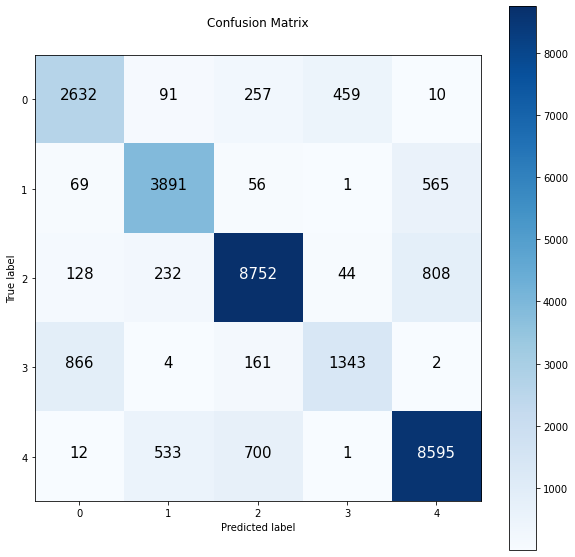

In [80]:
from helper_functions import make_confusion_matrix
make_confusion_matrix(val_labels_encoded, model5_preds) 
class_names